# Evaluation
Lecture Data Engineering and Analytics<br>
Eva Zangerle

In [2]:
from pprint import pprint
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.data import mnist_data
from sklearn import datasets, set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
%load_ext watermark
%watermark -a "Eva Zangerle" --updated --date --time --iversions --githash

Author: Eva Zangerle

Last updated: 2023-12-05 14:37:48



In [3]:
# specify data directory
data_dir = "../data"

In [3]:
# show all outputs
InteractiveShell.ast_node_interactivity = "all"

## Experimental Setup

After a first glimpse at a rather simple, lazy classification approach, we will discuss the systematic evaluation of classification approaches.

In a first step, we will define a `sklearn.pipeline` to define full workflows for the computation of classifications.

In [4]:
# define pipeline (with names)
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        # ('PCA', PCA()),
        ("knn", KNeighborsClassifier(n_neighbors=15)),
    ]
)

In [5]:
# revisit steps defined in pipeline
pipeline.steps

[('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=15))]

### Hold-out Cross Validation

In [6]:
# reload data
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2
)

In [8]:
# apply full pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=15))])

In [9]:
# run scorer on pipeline (standard for classificatoin is accuracy)
pipeline.score(X_test, y_test)

1.0

### k-Fold Cross Validation

In [10]:
knn = KNeighborsClassifier(
    n_neighbors=7, algorithm="kd_tree", leaf_size=30, metric="minkowski", p=1
)
cv = KFold(n_splits=10, random_state=0, shuffle=True)

accuracy_scores = []
# evaluate model based on individual folds
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)

    accuracy_scores.append(accuracy_score(y_predicted, y_test))

# report performance
print(
    f"Accuracy: {np.mean(accuracy_scores):.2f} (+/-{np.std(accuracy_scores):.2f})"
)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, p=1)

Accuracy: 0.95 (+/-0.07)


The above loop can be wrapped by scikit's cross_val_score function.
Note that this function also allows to parallelize the evaluation of individual folds; -1 uses all available processors.

In [11]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)
accuracy_scores = cross_val_score(
    pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1
)
for i in range(len(accuracy_scores)):
    print(f"Fold {i} accuracy score: {accuracy_scores[i]:.2f}")

# report performance
print(
    f"Accuracy: {np.mean(accuracy_scores):.2f} (+/-{np.std(accuracy_scores):.2f})"
)

Fold 0 accuracy score: 1.00
Fold 1 accuracy score: 1.00
Fold 2 accuracy score: 0.93
Fold 3 accuracy score: 0.80
Fold 4 accuracy score: 1.00
Fold 5 accuracy score: 1.00
Fold 6 accuracy score: 1.00
Fold 7 accuracy score: 1.00
Fold 8 accuracy score: 0.93
Fold 9 accuracy score: 1.00
Accuracy: 0.97 (+/-0.06)


Analoguously, we can also make use of the `StratifiedKFold` cross validator.

In [12]:
cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
accuracy_scores = cross_val_score(
    pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1
)
print(
    f"Accuracy: {np.mean(accuracy_scores):.2f} (+/- {np.std(accuracy_scores):.2f})"
)

Accuracy: 0.95 (+/- 0.03)


### Nested Cross Validation (5x2cv)

The following code example is adapted from (PyML).
It is based on a subset (stratified) of MNIST, using 5000 samples (10% of the original dataset). The dataset contains images of handwritten digits, represented in a square grid of pixels. 
The original MNIST dataset can be found here: http://yann.lecun.com/exdb/mnist/

In [13]:
# use non-html scikit output for better overview of outputs
set_config(display="text")

In [14]:
X, y = mnist_data()
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Initializing Classifiers
clf1 = KNeighborsClassifier(algorithm="ball_tree", leaf_size=50)
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = RandomForestClassifier(random_state=1)

# Building the pipelines
pipe1 = Pipeline([("std", StandardScaler()), ("clf1", clf1)])


# Setting up the parameter grids
param_grid1 = [{"clf1__n_neighbors": list(range(1, 10)), "clf1__p": [1, 2]}]

param_grid2 = [
    {
        "max_depth": list(range(1, 10)) + [None],
        "criterion": ["gini", "entropy"],
    }
]

param_grid3 = [{"n_estimators": [10, 100, 500, 1000]}]

In [15]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip(
    (param_grid1, param_grid2, param_grid3),
    (pipe1, clf2, clf3),
    ("KNN", "DTree", "RForest"),
):
    gcv = GridSearchCV(
        estimator=est,
        param_grid=pgrid,
        scoring="accuracy",
        n_jobs=-1,
        cv=inner_cv,
        verbose=0,
        refit=True,
    )
    gridcvs[name] = gcv

Next, we define the outer loop:
- The training folds from the outer loop will be used in the inner loop for model tuning
- The inner loop selects the best hyperparameter setting
- This best hyperparameter setting can be evaluated on both the avg. over the inner test folds and the 1 corresponding test fold of the outer loop

In [16]:

for name, gs_est in sorted(gridcvs.items()):

    print(50 * "-", "\n")
    print("Algorithm:", name)
    print("Inner loop:")

    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        # run inner loop hyperparam tuning
        gridcvs[name].fit(X_train[train_idx], y_train[train_idx])
        print(
            f"\nBest ACC (avg. of inner test folds): {gridcvs[name].best_score_ * 100:.2f}"
        )
        print(f"Best parameters: {gridcvs[name].best_params_}")

        # perf on test fold (valid_idx)
        outer_scores.append(
            gridcvs[name].best_estimator_.score(
                X_train[valid_idx], y_train[valid_idx]
            )
        )
        print(f"ACC (on outer test fold): {(outer_scores[-1]*100):.2f}")

    print("\n Outer Loop:")
    print(
        f"ACC {np.mean(outer_scores) * 100:.2f} (+/-{np.std(outer_scores) * 100:.2f})"
    )

-------------------------------------------------- 

Algorithm: DTree
Inner loop:


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 72.59
Best parameters: {'criterion': 'gini', 'max_depth': None}
ACC (on outer test fold): 75.50


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 74.03
Best parameters: {'criterion': 'entropy', 'max_depth': 7}
ACC (on outer test fold): 78.25


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 73.88
Best parameters: {'criterion': 'entropy', 'max_depth': 9}
ACC (on outer test fold): 77.38


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 73.38
Best parameters: {'criterion': 'entropy', 'max_depth': 8}
ACC (on outer test fold): 74.88


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 73.91
Best parameters: {'criterion': 'entropy', 'max_depth': 8}
ACC (on outer test fold): 77.75

 Outer Loop:
ACC 76.75 (+/-1.32)
-------------------------------------------------- 

Algorithm: KNN
Inner loop:


KeyboardInterrupt: 

## Hyperparameter Optimization

### Grid Search

In [ ]:
# define grid
# for each pipeline component (named), we can use the name as prefix
param_grid = {
    "knn__n_neighbors": list(range(1, 20)),
    "knn__weights": ["uniform", "distance"],
}

# apply grid search
grid_search = GridSearchCV(
    pipeline, param_grid, cv=10, scoring="accuracy", verbose=3
)
grid_search.fit(X, y)

# best results
print(
    f"Best parameter (CV score={grid_search.best_score_:0.3f}): \
      {grid_search.best_params_} ({grid_search.best_estimator_})"
)

In [ ]:
# inspect results in detail
results = pd.DataFrame(grid_search.cv_results_)
results

In [ ]:
# compare results visually
results.plot(
    x="param_knn__n_neighbors", y="mean_test_score", kind="bar", ylim=[0.8, 1]
)

## Metrics

In a first step, we will discuss the confusion matrix for our classifier. For the sake of simplicity, we will stick to our k-means classifier pipeline and hold-out cross  evaluation.

In [17]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
# for now, we stick to two features as input: sepal length and width
X = X[:, :2]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=2, test_size=0.2
)
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=15))])

In [19]:
confusion_matrix(y_test, y_predicted)

array([[13,  1,  0],
       [ 0,  4,  4],
       [ 0,  2,  6]])

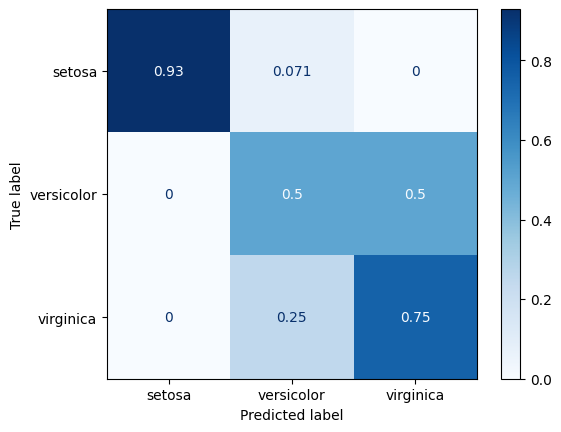

In [20]:
# prettify confusion matrix
# either normalized or non-normalized
cm_display = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test,
    y_test,
    display_labels=iris.target_names,
    cmap=plt.cm.Blues,
    normalize="true",
)

print(cm_display);

In [21]:
# classification report provides a  good overview of performance
print(
    classification_report(
        y_test, y_predicted, target_names=iris.target_names, zero_division=0
    )
)

              precision    recall  f1-score   support

      setosa       1.00      0.93      0.96        14
  versicolor       0.57      0.50      0.53         8
   virginica       0.60      0.75      0.67         8

    accuracy                           0.77        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.78      0.77      0.77        30



For binary classification tasks, we can also inspect the recall-precision curve. For the sake of simplicity, we will restrain the classifier to the first two classes and will use hold-out cross validation. You can find an extension to multi-class classification here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [22]:
# perform the classification based on two classes
X_2_classes, y_2_classes = X[y != 2], y[y != 2]

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X_2_classes.shape
X_2_classes = np.concatenate(
    [X_2_classes, random_state.randn(n_samples, 200 * n_features)], axis=1
)
X_train, X_test, y_train, y_test = train_test_split(
    X_2_classes, y_2_classes, test_size=0.5, random_state=random_state
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=15))])

Text(0.5, 1.0, '2-class Precision-Recall curve')

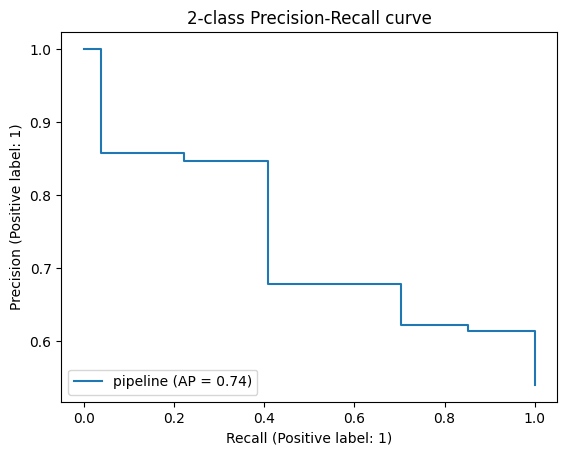

In [23]:
display = PrecisionRecallDisplay.from_estimator(
    pipeline, X_test, y_test, name="pipeline"
)
display.ax_.set_title("2-class Precision-Recall curve")

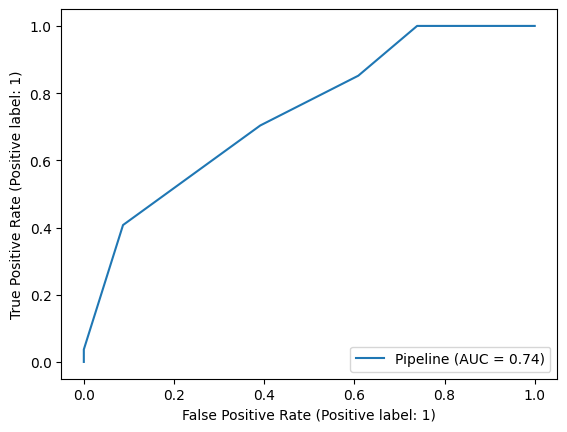

In [24]:
# receiver operating curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

When using k-Fold cross validation, we can still collect the predictions and compute the confusion matrix.

In [25]:
cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
y_predicted = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
confusion_matrix(y, y_predicted)

array([[49,  1,  0],
       [ 0, 32, 18],
       [ 0, 15, 35]])

From the confusion matrix, further single-digit evaluation metrics for classification can be computed as follows. Note that we now use `cross_validate` instead of `cross_val_score` as it allows us to specify multiple evaluation metrics and also provides us with time information.

In [26]:
# specify metrics to be computed
scoring = {
    "acc": "accuracy",
    "prec_macro": "precision_macro",
    "prec_micro": "precision_micro",
    "rec_macro": "recall_macro",
    "rec_micro": "recall_micro",
}
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
pprint(scores)

{'fit_time': array([0.02207589, 0.00587821, 0.03812504, 0.00546241, 0.03396392,
       0.03957653, 0.03305745, 0.00644541, 0.00548387, 0.00802231]),
 'score_time': array([0.12838507, 0.14690614, 0.06322765, 0.08399868, 0.16038084,
       0.18341231, 0.16322756, 0.0414505 , 0.03531241, 0.0648725 ]),
 'test_acc': array([0.86666667, 0.73333333, 0.73333333, 0.73333333, 0.66666667,
       1.        , 0.66666667, 0.86666667, 0.8       , 0.66666667]),
 'test_prec_macro': array([0.86666667, 0.73333333, 0.74603175, 0.73333333, 0.69047619,
       1.        , 0.66666667, 0.86666667, 0.80555556, 0.66666667]),
 'test_prec_micro': array([0.86666667, 0.73333333, 0.73333333, 0.73333333, 0.66666667,
       1.        , 0.66666667, 0.86666667, 0.8       , 0.66666667]),
 'test_rec_macro': array([0.86666667, 0.73333333, 0.73333333, 0.73333333, 0.66666667,
       1.        , 0.66666667, 0.86666667, 0.8       , 0.66666667]),
 'test_rec_micro': array([0.86666667, 0.73333333, 0.73333333, 0.73333333, 0.66666667